In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader
import datetime as dt
import yfinance as yf
import os 
import pandas_ta as ta
import keras_tuner as kt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, LSTM, Input
from keras_tuner import RandomSearch, HyperModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [3]:
# Load Data
def get_data(symbol: str, start_date: str, end_date: str, timeframe: str = "1d") -> pd.DataFrame:
    data = yf.download(symbol,start=start_date, end=end_date, interval=timeframe)
    return data

In [4]:
company = "^NSEI"
start_date = dt.datetime(2020,1,1)
end_date = dt.datetime(2024,1,1)


In [5]:
data = get_data(company, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [6]:
print(data)
len(data)

                    Open          High           Low         Close  \
Date                                                                 
2020-01-01  12202.150391  12222.200195  12165.299805  12182.500000   
2020-01-02  12198.549805  12289.900391  12195.250000  12282.200195   
2020-01-03  12261.099609  12265.599609  12191.349609  12226.650391   
2020-01-06  12170.599609  12179.099609  11974.200195  11993.049805   
2020-01-07  12079.099609  12152.150391  12005.349609  12052.950195   
...                  ...           ...           ...           ...   
2023-12-22  21295.849609  21390.500000  21232.449219  21349.400391   
2023-12-26  21365.199219  21477.150391  21329.449219  21441.349609   
2023-12-27  21497.650391  21675.750000  21495.800781  21654.750000   
2023-12-28  21715.000000  21801.449219  21678.000000  21778.699219   
2023-12-29  21737.650391  21770.300781  21676.900391  21731.400391   

               Adj Close  Volume  
Date                              
2020-01-01  12182.5

991

In [7]:
# Feature Engineering
def calculate_technical_indicators(data):
    data['Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data['Volatility'] = data['Returns'].rolling(window=10).std() * np.sqrt(252)
    data['50_MA'] = data['Adj Close'].rolling(window=50).mean()
    data['20_MA'] = data['Adj Close'].rolling(window=20).mean()
    data['EMA_Fast'] = ta.ema(data['Adj Close'], length=12)
    data['EMA_Mid'] = ta.ema(data['Adj Close'], length=26)
    data['EMA_Slow'] = ta.ema(data['Adj Close'], length=50)
    data['RSI'] = ta.rsi(data['Adj Close'], length=14)
    macd = ta.macd(data['Adj Close'], fast=12, slow=26, signal=9)
    data['MACD'] = macd['MACD_12_26_9']
    data['MACD_Signal'] = macd['MACDs_12_26_9']
    data.dropna(inplace=True)
    return data

In [8]:
data = calculate_technical_indicators(data)

data.head()

,Open,High,Low,Close,Adj Close,Volume,Returns,Volatility,50_MA,20_MA,EMA_Fast,EMA_Mid,EMA_Slow,RSI,MACD,MACD_Signal
Date,,,,,,,,,,,,,,,,
2020-03-12,10039.950195,10040.750000,9508.000000,9590.150391,9590.150391,1343500,-0.086669,0.488382,11873.672031,11466.035107,10922.616459,11387.020501,11873.672031,12.596991,-464.404041,-288.919484
2020-03-13,9107.599609,10159.400391,8555.150391,9955.200195,9955.200195,1388000,0.037358,0.563834,11829.126035,11353.735107,10773.783188,11280.959737,11798.437842,24.048260,-507.176549,-332.570897
2020-03-16,9587.799805,9602.200195,9165.099609,9197.400391,9197.400391,897700,-0.079174,0.642287,11767.430039,11204.872607,10531.262757,11126.622008,11696.436373,18.600297,-595.359250,-385.128568
2020-03-17,9285.400391,9403.799805,8915.599609,8967.049805,8967.049805,935600,-0.025364,0.638173,11702.238027,11047.552588,10290.614611,10966.653696,11589.401606,17.316131,-676.039086,-443.310671
2020-03-18,9088.450195,9127.549805,8407.049805,8468.799805,8468.799805,1516600,-0.057168,0.624468,11631.753027,10868.702588,10010.335410,10781.627482,11467.025064,14.917137,-771.292072,-508.906951


In [9]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Adj Close', 'Returns', 'Volatility', '50_MA', '20_MA', 'EMA_Fast', 'EMA_Mid', 'EMA_Slow', 'RSI', 'MACD', 'MACD_Signal']])


In [10]:
print(scaled_data)
print((scaled_data.size))

[[0.13974009 0.23479418 0.43056562 ... 0.         0.37345254 0.44604762]
 [0.16550507 0.79086994 0.50308991 ... 0.15686301 0.34417961 0.41152641]
 [0.11202005 0.26839695 0.57849995 ... 0.08223513 0.28382854 0.36996178]
 ...
 [0.99125174 0.66777604 0.08140804 ... 0.88221847 0.97377388 0.99349286]
 [1.         0.64896338 0.08097376 ... 0.90507867 0.98245107 0.99699265]
 [0.99666168 0.61362577 0.07550275 ... 0.87387565 0.98334902 1.        ]]
10362


In [11]:
# Preparing data for LSTM
prediction_days = 200

In [12]:
x_train, y_train = [], []
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x])
    y_train.append(scaled_data[x, 0])  # Predict the 'Adj Close' price


In [13]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

In [17]:
# Hyperparameter Tuning
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
        x = LSTM(units=hp.Int('units_lstm1', min_value=50, max_value=200, step=25), return_sequences=True)(inputs)
        x = Dropout(hp.Float('dropout_lstm1', min_value=0.1, max_value=0.5, step=0.1))(x)
        x = LSTM(units=hp.Int('units_lstm2', min_value=50, max_value=200, step=25), return_sequences=False)(x)
        x = Dropout(hp.Float('dropout_lstm2', min_value=0.1, max_value=0.5, step=0.1))(x)
        x = Dense(units=hp.Int('units_dense', min_value=10, max_value=50, step=5))(x)
        outputs = Dense(1)(x)

        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')), loss='mean_squared_error')
        return model

In [19]:

# Initialize Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    LSTMHyperModel(),
    objective='val_loss',  # Optimize for validation loss
    max_trials=5,          # Number of trials
    executions_per_trial=2, # Averaging over 2 trials
    directory='tuner',
    project_name='stock_prediction_tuning3'
)


In [20]:
tuner.search(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

Trial 5 Complete [00h 04m 09s]
val_loss: 0.000681231205817312

Best val_loss So Far: 0.00043716207437682897
Total elapsed time: 00h 35m 52s


In [22]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the best model
model = tuner.hypermodel.build(best_hps)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 557ms/step - loss: 0.2186 - val_loss: 0.0249
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 529ms/step - loss: 0.0068 - val_loss: 0.0033
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 526ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 528ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 525ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 545ms/step - loss: 0.0021 - val_loss: 7.3299e-04
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 507ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 8/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 527ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 9/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 522ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 536ms/step - loss: 0.0018 - val_loss: 6.6249e-04
Epoch 11/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 523ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 12/25
21/21 ━━━━━━━━━━━━━━━

In [23]:
# Testing the Model
test_start = start_date
test_end = end_date
test_data = get_data(company, test_start, test_end)
test_data = calculate_technical_indicators(test_data)

[*********************100%%**********************]  1 of 1 completed


In [24]:
# Scale the test data
scaled_test_data = scaler.transform(test_data[['Adj Close', 'Returns', 'Volatility', '50_MA', '20_MA', 'EMA_Fast', 'EMA_Mid', 'EMA_Slow', 'RSI', 'MACD', 'MACD_Signal']])

In [25]:
x_test, y_test = [], []
for x in range(prediction_days, len(scaled_test_data)):
    x_test.append(scaled_test_data[x - prediction_days:x])
    y_test.append(scaled_test_data[x, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

In [26]:
# Make predictions
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(np.hstack((predicted_prices, np.zeros((predicted_prices.shape[0], 10)))))[:, 0]

actual_prices = test_data['Adj Close'].values[-len(predicted_prices):]

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step


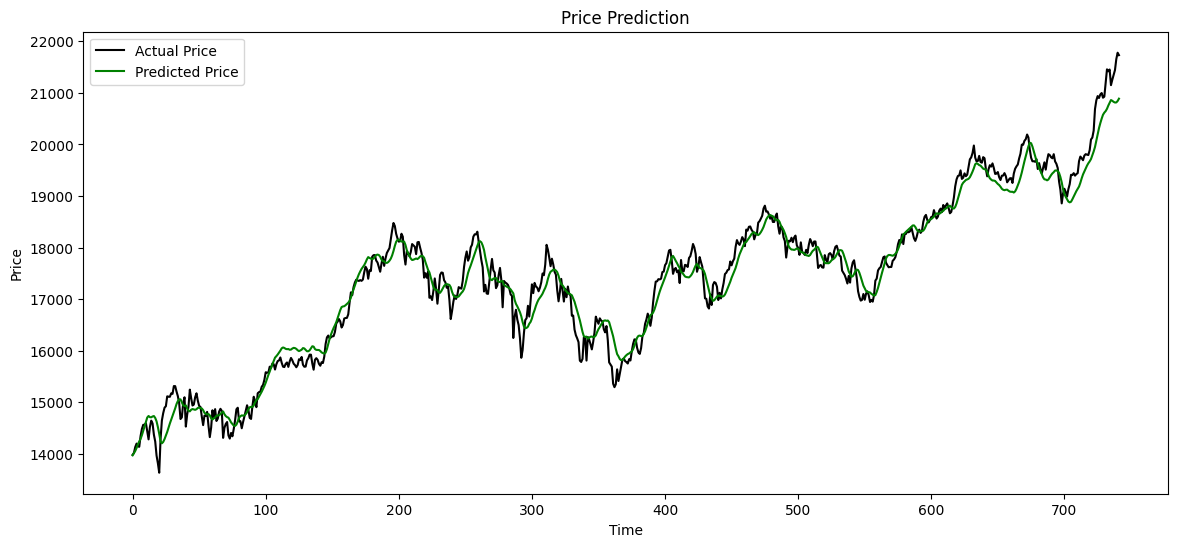

In [27]:
# Plot Predictions vs Actual Prices
plt.figure(figsize=(14, 6))
plt.plot(actual_prices, color='black', label='Actual Price')
plt.plot(predicted_prices, color='green', label='Predicted Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
# Performance Metrics
mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 82374.85128149088
Mean Absolute Error: 225.7068191198208


In [29]:
# Calculate Returns Performance
test_data['Predicted Price'] = np.nan

# Use .iloc[] for positional indexing
test_data.iloc[-len(predicted_prices):, test_data.columns.get_loc('Predicted Price')] = predicted_prices

# Calculate Predicted Returns and Strategy Returns
test_data['Predicted Returns'] = np.log(test_data['Predicted Price'] / test_data['Predicted Price'].shift(1))
test_data['Strategy Returns'] = test_data['Predicted Returns'].shift(1) * np.sign(test_data['Returns'])

cumulative_strategy_returns = np.exp(test_data['Strategy Returns'].cumsum())
cumulative_market_returns = np.exp(test_data['Returns'].cumsum())

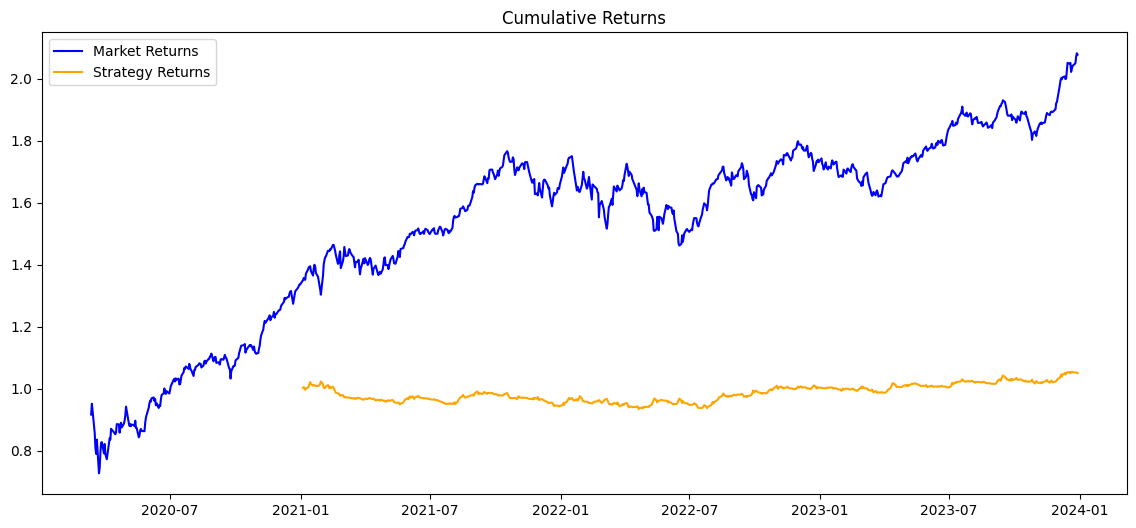

In [30]:
# Plot cumulative returns
plt.figure(figsize=(14, 6))
plt.plot(cumulative_market_returns, color='blue', label='Market Returns')
plt.plot(cumulative_strategy_returns, color='orange', label='Strategy Returns')
plt.title('Cumulative Returns')
plt.legend()
plt.show()

In [31]:
# Risk Factors
volatility = test_data['Returns'].std() * np.sqrt(252)
max_drawdown = ((test_data['Adj Close'].cummax() - test_data['Adj Close']) / test_data['Adj Close'].cummax()).max()


In [32]:
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'Volatility (Annualized): {volatility}')
print(f'Maximum Drawdown: {max_drawdown}')

MSE: 82374.85128149088
MAE: 225.7068191198208
Volatility (Annualized): 0.20346288277754507
Maximum Drawdown: 0.2355502801858914
